<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/seed4_(BI_LSTM)100_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pickle

In [3]:
df = pd.read_csv('/content/SEED_IV_de_LDS_flattened.csv')

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=4)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape: (samples, 62 timesteps, 5 features)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)


In [4]:
def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    merged = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(62 * 5, activation='tanh')(x)
    x = tf.keras.layers.Reshape((62, 5))(x)
    return Model([noise_input, label_input], x)


def build_discriminator(input_shape, num_classes):
    data_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    x = tf.keras.layers.Flatten()(data_input)
    merged = Concatenate()([x, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(1, activation='sigmoid')(x)
    return Model([data_input, label_input], x)


latent_dim = 100
num_classes = 4
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((62, 5), num_classes)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Combined GAN
discriminator.trainable = False
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))
generated_sample = generator([noise_input, label_input])
validity = discriminator([generated_sample, label_input])
cgan = Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')


In [5]:
cgan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 62, 5)     │     53,430 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │     40,449 │ functional[0][0], │
│ (Functional)        │                   │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,879 (366.71 KB)

 Trainable params: 53,430 (208.71 KB)

 Non-trainable params: 40,449 (158.00 KB)

In [12]:
def train_gan(epochs=5000, batch_size=64):
    for epoch in range(epochs):

        discriminator.trainable = True

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict([noise, real_labels])

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_samples, real_labels], fake_y)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, real_labels], real_y)

        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
train_gan(epochs=5000)


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [13]:
def generate_synthetic_samples(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    random_classes = np.random.randint(0, num_classes, n_samples)
    labels_categorical = to_categorical(random_classes, num_classes=num_classes)
    synthetic_data = generator.predict([noise, labels_categorical])
    return synthetic_data, labels_categorical

synthetic_X, synthetic_y = generate_synthetic_samples(10000)

# Combine real + synthetic
X_combined = np.concatenate((X_train, synthetic_X), axis=0)
y_combined = np.concatenate((y_train, synthetic_y), axis=0)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [15]:
from collections import Counter
import numpy as np

# Convert one-hot encoded labels back to integer indices
train_labels = np.argmax(y_combined, axis=1)

# Decode class indices to label names
label_names = le.inverse_transform(np.arange(len(le.classes_)))

# Count occurrences
class_counts = Counter(train_labels)

# Display counts with emotion names
for idx in sorted(class_counts.keys()):
    print(f"{label_names[idx]}: {class_counts[idx]} samples")


fear: 9942 samples
happy: 8891 samples
neutral: 10590 samples
sad: 10637 samples


In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_combined.shape)
print(y_combined.shape)

(30060, 62, 5)
(30060, 4)
(7515, 62, 5)
(7515, 4)
(40060, 62, 5)
(40060, 4)


In [17]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(62, 5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 7 emotions
])



model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# history = model.fit(
#     train_dataset,
#     epochs=100,
#     validation_data=test_dataset
# )
history1 = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset
)

# Evaluate accuracy
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy after 50 epochs: {test_acc:.4f}")

# Save the model
model.save('emotion_model_50_epochs.h5')


Epoch 1/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.4361 - loss: 1.1987 - val_accuracy: 0.7373 - val_loss: 0.6772
Epoch 2/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.7854 - loss: 0.5602 - val_accuracy: 0.8997 - val_loss: 0.3030
Epoch 3/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9055 - loss: 0.2785 - val_accuracy: 0.9638 - val_loss: 0.1325
Epoch 4/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9609 - loss: 0.1295 - val_accuracy: 0.9569 - val_loss: 0.1277
Epoch 5/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9547 - loss: 0.1418 - val_accuracy: 0.9762 - val_loss: 0.0761
Epoch 6/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9695 - loss: 0.0949 - val_accuracy: 0.9884 - val_loss: 0.0387
Epoch 7/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9668 - loss: 0.1039 - val_accuracy: 0.9935 - val_loss: 0.0177
Epoch 8/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9826 - loss: 0.0585 - 

Test Accuracy after 50 epochs: 0.9888


In [34]:
# Load the model
model = tf.keras.models.load_model('emotion_model_50_epochs.h5')

# Re-compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Continue training from epoch 51 to 100
history2 = model.fit(
    train_dataset,
    epochs=100,
    initial_epoch=50,
    validation_data=test_dataset
)

# Evaluate again
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy after 100 epochs: {test_acc:.4f}")

# Save the final model
model.save('emotion_model_100_epochs.h5')


Epoch 51/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.9896 - loss: 0.0359 - val_accuracy: 0.9948 - val_loss: 0.0236
Epoch 52/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9978 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 6.4022e-04
Epoch 53/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9966 - loss: 0.0128 - val_accuracy: 0.9875 - val_loss: 0.0403
Epoch 54/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9973 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 55/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.9941 - val_loss: 0.0332
Epoch 56/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9759 - loss: 0.0916 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 57/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.2129e-04
Epoch 58/100
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 

Test Accuracy after 100 epochs: 1.0000


In [18]:
#50epochs
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9888 - loss: 0.0470
Test Accuracy: 98.88%


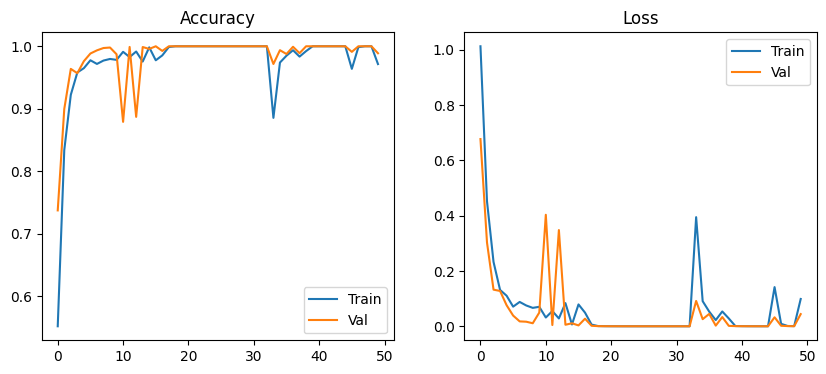

In [20]:
#50epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

        fear       0.99      1.00      0.99      1820
       happy       0.98      0.98      0.98      1600
     neutral       0.98      0.98      0.98      2038
         sad       1.00      0.99      0.99      2057

    accuracy                           0.99      7515
   macro avg       0.99      0.99      0.99      7515
weighted avg       0.99      0.99      0.99      7515



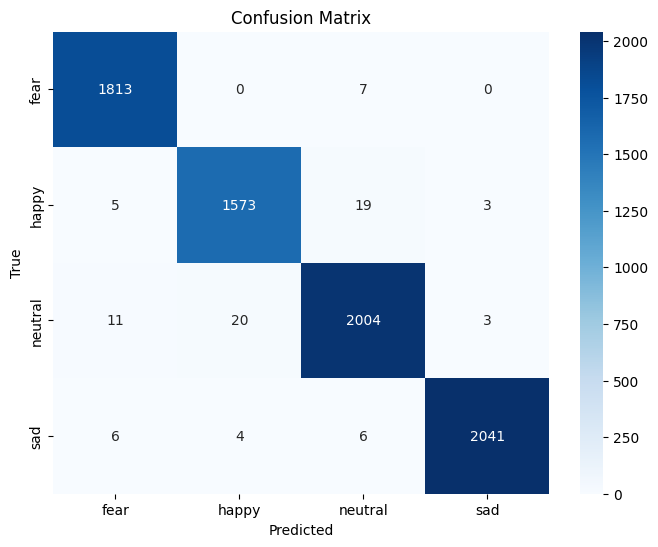

In [21]:
#50 epochs
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



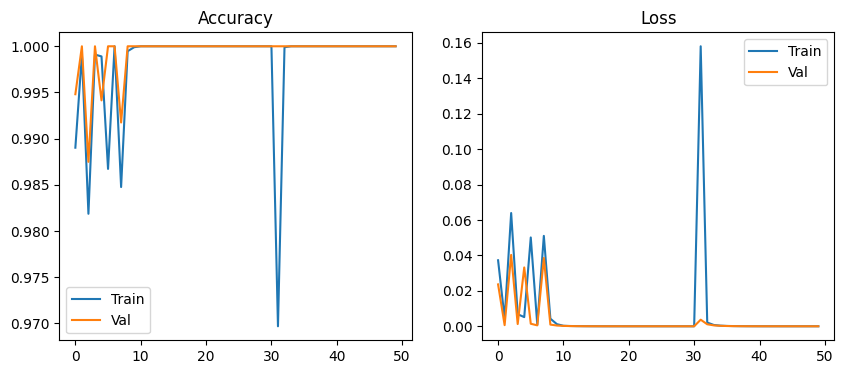

In [35]:
#100epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

        fear       1.00      1.00      1.00      1820
       happy       1.00      1.00      1.00      1600
     neutral       1.00      1.00      1.00      2038
         sad       1.00      1.00      1.00      2057

    accuracy                           1.00      7515
   macro avg       1.00      1.00      1.00      7515
weighted avg       1.00      1.00      1.00      7515



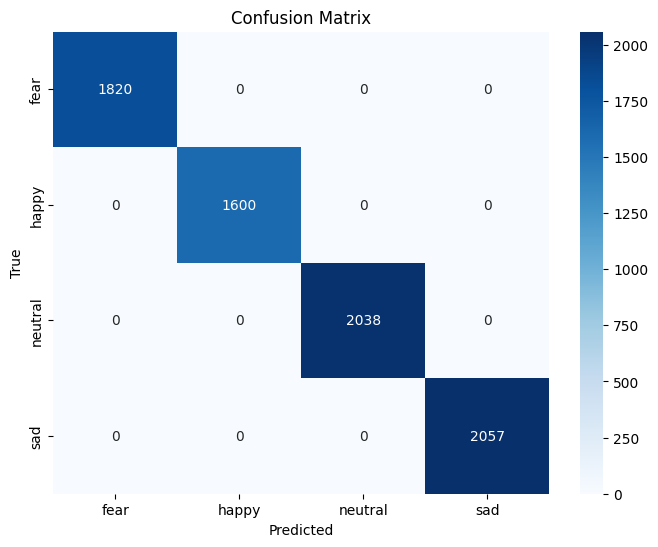

In [36]:
#100 epochs
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [24]:
# model.save("eeg_emotion_gan_model.h5")
# with open('eeg_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
with open('eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Model and preprocessors saved.")

Model and preprocessors saved.


In [25]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
import pickle
import os

# Define the save path
save_path = '/content/drive/MyDrive/EEG_Models(seed4)'
os.makedirs(save_path, exist_ok=True)

# Save the label encoder
with open(os.path.join(save_path, 'eeg_label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

print("Label encoder saved to Google Drive.")


Label encoder saved to Google Drive.
